In [38]:
import argparse
import re
import networkx as nx
import scipy as scipy
import matplotlib.pyplot as plt # for visualizing GMLs
import os
import itertools
%matplotlib inline
import pandas as pd
import numpy as np
import sklearn.metrics as sklearn_metrics
#from sklearn.metrics import rand_score

In [78]:
# Mapping Clusters of Orthologous Genes (COGs) between two pan-genome gene graphs

In [2]:
def conv_list(maybe_list):
    if not isinstance(maybe_list, list):
        maybe_list = [maybe_list]
    return (maybe_list)

def update_sid(sid, member_count):
    sid = sid.split("_")
    sid[0] = str(member_count + int(sid[0].replace("'", "")))
    return ("_".join(sid))

def del_dups(iterable):
    seen = {}
    for f in iterable:
        seen[f] = None
    return (list(seen.keys()))

def load_graphs(graph_files, n_cpu=1):
    for graph_file in graph_files:
        if not os.path.isfile(graph_file):
            print("Missing:", graph_file)
            raise RuntimeError("Missing graph file!")

    graphs = [nx.read_gml(graph_file) for graph_file in graph_files]
    isolate_names = list(
        itertools.chain.from_iterable(
            [G.graph['isolateNames'] for G in graphs]))

    member_count = 0
    node_count = 0
    id_mapping = []
    for i, G in enumerate(graphs):
        id_mapping.append({})
        # relabel nodes to be consecutive integers from 1
        mapping = {}
        for n in G.nodes():
            mapping[n] = node_count
            node_count += 1
        G = nx.relabel_nodes(G, mapping, copy=True)

        # set up edge members and remove conflicts.
        for e in G.edges():
            G[e[0]][e[1]]['members'] = [
                m + member_count for m in conv_list(G[e[0]][e[1]]['members'])
            ]

        # set up node parameters and remove conflicts.
        max_mem = -1
        for n in G.nodes():
            ncentroids = []
            for sid in G.nodes[n]['centroid'].split(";"):
                nid = update_sid(sid, member_count)
                id_mapping[i][sid] = nid
                if "refound" not in nid:
                    ncentroids.append(nid)
            G.nodes[n]['centroid'] = ncentroids
            new_ids = set()
            for sid in conv_list(G.nodes[n]['seqIDs']):
                nid = update_sid(sid, member_count)
                id_mapping[i][sid] = nid
                new_ids.add(nid)
            G.nodes[n]['seqIDs'] = new_ids
            G.nodes[n]['protein'] = del_dups(G.nodes[n]['protein'].replace(
                '*', 'J').split(";"))
            G.nodes[n]['dna'] = del_dups(G.nodes[n]['dna'].split(";"))
            G.nodes[n]['lengths'] = conv_list(G.nodes[n]['lengths'])
            G.nodes[n]['longCentroidID'][1] = update_sid(
                G.nodes[n]['longCentroidID'][1], member_count)
            G.nodes[n]['members'] = [m + member_count for m in conv_list(G.nodes[n]['members'])]
            max_mem = max(max_mem, max(G.nodes[n]['members']))

        member_count = max_mem + 1
        graphs[i] = G

    return graphs, isolate_names, id_mapping

In [3]:
### read in two graphs

graph_files = ["../../graph_1/final_graph.gml", "../../graph_2/final_graph.gml"]

graphs, isolate_names, id_mapping = load_graphs(graph_files)

sim_graph_04 = graphs[0]
sim_graph_59 = graphs[1]

#list(sim_graph_04.nodes(data=True))

In [8]:
### map nodes from ggcaller graphs to the COG labels in the centroid from pangenome

# read into df
# each "group_" refers to the centroid of that group in the pan_genomes_reference.fa
mmseqs = pd.read_csv('../../graph_merged/mmseqs_alignments.m8', sep='\t')

In [9]:
### match hits from mmseqs

# change the second graph node names to the first graph node names for nodes that match according to mmseqs

# make sure metrics are numeric
mmseqs["fident"] = pd.to_numeric(mmseqs["fident"], errors='coerce')
mmseqs["evalue"] = pd.to_numeric(mmseqs["evalue"], errors='coerce')
mmseqs["tlen"] = pd.to_numeric(mmseqs["tlen"], errors='coerce')
mmseqs["qlen"] = pd.to_numeric(mmseqs["qlen"], errors='coerce')
mmseqs["nident"] = pd.to_numeric(mmseqs["nident"], errors='coerce')

# filter for nt identity >= 98% (global) and length difference <= 5%
max_len = np.maximum(mmseqs['tlen'], mmseqs['qlen'])
#nt_identity = mmseqs['nident'] / max_len  >= 0.98
nt_identity = max_len / max_len  >= 0.98 #TEMPORARILY - SINCE NT IDENTITY VERY LOW IN CAPSULE LOCI
len_dif = 1-(np.abs(mmseqs['tlen'] - mmseqs['qlen']) / max_len) >= 0.95

scores = nt_identity & len_dif
mmseqs = mmseqs[scores].copy()

# iterate over target with each unique value of target, and pick the match with the highest fident; if multiple, pick the one with the smaller E value

# sort by fident (highest first) and evalue (lowest first)
mmseqs_sorted = mmseqs.sort_values(by=["fident", "evalue"], ascending=[False, True])

# only keep the first occurrence per unique target (highest fident then smallest evalue if tie)
mmseqs_filtered = mmseqs_sorted.groupby("target", as_index=False).first()

# remove "group_" prefix, keep as string
#mmseqs_filtered = mmseqs_filtered.applymap(lambda x: x.replace("group_", "") if isinstance(x, str) else x)

In [10]:
# in mmseqs, the first graph entered (in this case graph_1) is the query and the second entered (in this case graph_2) is the target
# so graph_1 is our query in mmseqs and the basegraph in the tokenized merge

# when iterating over the graph used to append the basegraph (graph_2), we want to match nodes according to their graph_1 identity
# so we first need to replace all graph_2 nodes with graph_1 node ids

### THE NAME ("group_1") AND THE LABEL ('484') ARE DIFFERENT AND A NUMERIC STRING WILL CALL THE LABEL (not index)

mapping_groups_1 = dict()
for node in sim_graph_04.nodes():
    node_group = sim_graph_04.nodes[node].get("name", "error")
    #print(f"graph: 1, node_index_id: {node}, node_group_id: {node_group}")
    mapping_groups_1[int(node)] = str(node_group)

groupmapped_graph_1 = nx.relabel_nodes(sim_graph_04, mapping_groups_1, copy=True)

mapping_groups_2 = dict()
for node in sim_graph_59.nodes():
    node_group = sim_graph_59.nodes[node].get("name", "error")
    #print(f"graph: 1, node_index_id: {node}, node_group_id: {node_group}")
    mapping_groups_2[int(node)] = str(node_group)

groupmapped_graph_2 = nx.relabel_nodes(sim_graph_59, mapping_groups_2, copy=True)

In [11]:
### map filtered mmseqs2 hits to mapping of nodes between graphs

# mapping format: dictionary with old labels as keys and new labels as values

# convert df to dictionary with "target" as keys and "query" as values
mapping = dict(zip(mmseqs_filtered["target"], mmseqs_filtered["query"]))

### to avoid matching nodes from target that have the same group_id but are not the same:
# append all nodes in query graph with _query
# append all query nodes in target graph with _query (for later matching)

mapping = {key: f"{value}_query" for key, value in mapping.items()}

# relabel target graph
relabeled_graph_2 = nx.relabel_nodes(groupmapped_graph_2, mapping, copy=True)

# relabel query graph
mapping_query = dict(zip(groupmapped_graph_1.nodes, groupmapped_graph_1.nodes))

# temporarily stop appending with query to see if that fixes the node issue
mapping_query = {key: f"{value}_query" for key, value in mapping_query.items()}

relabeled_graph_1 = nx.relabel_nodes(groupmapped_graph_1, mapping_query, copy=True)

### need to do this to edges as well
#print(relabeled_graph_1.edges)
#print(relabeled_graph_2.edges)
# looks like this is done automatically

# now we can modify the tokenized code to iterate like usual, adding new node if string doesn't contain "_query"
# and merging the nodes that both end in "_query"

In [25]:
# to double-check above
if set(relabeled_graph_1.nodes) == set(relabeled_graph_2.nodes):
    print("The node sets are identical.")
else:
    print("The node sets are different.")
    
nodes_1 = set(relabeled_graph_1.nodes)
nodes_2 = set(relabeled_graph_2.nodes)

common_nodes = nodes_1 & nodes_2  # Intersection (nodes in both graphs)
only_in_graph_1 = nodes_1 - nodes_2  # Nodes only in Graph 1
only_in_graph_2 = nodes_2 - nodes_1  # Nodes only in Graph 2

print(f"Common Nodes: {common_nodes}")
print(f"Nodes only in Graph 1: {only_in_graph_1}")
print(f"Nodes only in Graph 2: {only_in_graph_2}")

The node sets are different.
Common Nodes: {'group_200_query', 'group_145_query', 'group_100_query', 'group_31_query', 'group_122_query', 'group_189_query', 'group_134_query', 'group_182_query', 'group_144_query', 'group_57_query', 'group_158_query', 'group_213_query', 'group_10_query', 'group_216_query', 'group_54_query', 'group_63_query', 'group_241_query', 'group_138_query', 'group_236_query', 'group_174_query', 'group_247_query', 'group_237_query', 'group_218_query', 'group_170_query', 'group_11_query', 'group_45_query', 'group_102_query', 'group_238_query', 'group_96_query', 'group_9_query', 'group_171_query', 'group_235_query', 'group_120_query', 'group_185_query', 'group_49_query', 'group_87_query', 'group_79_query', 'group_140_query', 'group_149_query', 'group_13_query', 'group_184_query', 'group_207_query', 'group_97_query', 'group_68_query', 'group_205_query', 'group_199_query', 'group_4_query', 'group_133_query', 'group_231_query', 'group_168_query', 'group_159_query', 'grou

In [ ]:
# !! not needed now that panaroo is run separately !!
# (panaroo standalone outputs "group_x" instead)

# actually still needed to make integers for the run
# this time, only need to remove "group_" from each node

# tokenize clusters by replacing each unique value in the mmseqs alignment output with an integer
# replace query COG names

#unique_clusters_query = alignments['query'].unique()
#alignments['query'].replace(to_replace=unique_clusters_query,
#           value= list(range(len(unique_clusters_query))),
#           inplace=True)

# replace target COG names
#unique_clusters_target = alignments['target'].unique()
#alignments['target'].replace(to_replace=unique_clusters_target,
#           value= list(range(len(unique_clusters_query))),
#           inplace=True)

In [13]:
# add metadata when merging

### FROM PANAROO MERGE_NODES.PY

import itertools
from collections import Counter
#from .isvalid import del_dups
import numpy as np
#from intbitset import intbitset


def gen_node_iterables(G, nodes, feature, split=None):
    for n in nodes:
        if split is None:
            yield G.nodes[n][feature]
        else:
            yield G.nodes[n][feature].split(split)


def gen_edge_iterables(G, edges, feature):
    for e in edges:
        yield G[e[0]][e[1]][feature]


def temp_iter(list_list):
    for n in list_list:
        yield n


def iter_del_dups(iterable):
    seen = {}
    for f in itertools.chain.from_iterable(iterable):
        seen[f] = None
    return (list(seen.keys()))


def del_dups(iterable):
    seen = {}
    for f in iterable:
        seen[f] = None
    return (list(seen.keys()))


def merge_node_cluster(G,
                       nodes,
                       newNode,
                       multi_centroid=True,
                       check_merge_mems=True):

    if check_merge_mems:
        mem_count = Counter(
            itertools.chain.from_iterable(
                gen_node_iterables(G, nodes, 'members')))
        #if max(mem_count.values()) > 1:
            #instead of following error (while genome IDs can be identical since they're being merged)
            #raise ValueError("merging nodes with the same genome IDs!")

    # take node with most support as the 'consensus'
    nodes = sorted(nodes, key=lambda x: G.nodes[x]['size'])

    # First create a new node and combine the attributes
    dna = iter_del_dups(gen_node_iterables(G, nodes, 'dna'))
    maxLenId = 0
    max_l = 0
    for i, s in enumerate(dna):
        if len(s) >= max_l:
            max_l = len(s)
            maxLenId = i

    members = G.nodes[nodes[0]]['members'].copy()
    for n in nodes[1:]:
        members = list(dict.fromkeys(G.nodes[n]['members']))

    if multi_centroid:
        mergedDNA = any(gen_node_iterables(G, nodes, 'mergedDNA'))
    else:
        mergedDNA = True

    G.add_node(
        newNode,
        size=len(members),
        centroid=iter_del_dups(gen_node_iterables(G, nodes, 'centroid')),
        maxLenId=maxLenId,
        members=members,
        seqIDs=set(iter_del_dups(gen_node_iterables(G, nodes, 'seqIDs'))),
        hasEnd=any(gen_node_iterables(G, nodes, 'hasEnd')),
        protein=iter_del_dups(gen_node_iterables(G, nodes, 'protein')),
        dna=dna,
        annotation=";".join(
            iter_del_dups(gen_node_iterables(G, nodes, 'annotation',
                                             split=";"))),
        description=";".join(
            iter_del_dups(
                gen_node_iterables(G, nodes, 'description', split=";"))),
        lengths=list(
            itertools.chain.from_iterable(
                gen_node_iterables(G, nodes, 'lengths'))),
        longCentroidID=max(gen_node_iterables(G, nodes, 'longCentroidID')),
        paralog=any(gen_node_iterables(G, nodes, 'paralog')),
        mergedDNA=mergedDNA)
    if "prevCentroids" in G.nodes[nodes[0]]:
        G.nodes[newNode]['prevCentroids'] = ";".join(
            set(
                iter_del_dups(
                    gen_node_iterables(G, nodes, 'prevCentroids', split=";"))))

    # Now iterate through neighbours of each node and add them to the new node
    merge_nodes = set(nodes)
    for node in nodes:
        for neighbour in G.neighbors(node):
            if neighbour in merge_nodes: continue
            if G.has_edge(newNode, neighbour):
                G[newNode][neighbour]['members'] = list(dict.fromkeys(G[node][neighbour][
                    'members']))
                G[newNode][neighbour]['size'] = len(G[newNode][neighbour]['members'])
            else:
                G.add_edge(newNode,
                           neighbour,
                           size=G[node][neighbour]['size'],
                           members=G[node][neighbour]['members'])

    # remove old nodes from Graph
    G.remove_nodes_from(nodes)

    return G


def delete_node(G, node):
    # add in new edges
    for mem in G.nodes[node]['members']:
        mem_edges = list(
            set([e[1] for e in G.edges(node) if mem in G.edges[e]['members']]))
        if len(mem_edges) < 2: continue
        for n1, n2 in itertools.combinations(mem_edges, 2):
            if G.has_edge(n1, n2):
                G[n1][n2]['members'] |= intbitset([mem])
                G[n1][n2]['size'] = len(G[n1][n2]['members'])
            else:
                G.add_edge(n1, n2, size=1, members=intbitset([mem]))

    # now remove node
    G.remove_node(node)

    return G


def remove_member_from_node(G, node, member):

    # add in replacement edges if required
    mem_edges = list(
        set([e[1] for e in G.edges(node) if member in G.edges[e]['members']]))
    if len(mem_edges) > 1:
        for n1, n2 in itertools.combinations(mem_edges, 2):
            if G.has_edge(n1, n2):
                G[n1][n2]['members'] |= intbitset([member])
                G[n1][n2]['size'] = len(G[n1][n2]['members'])
            else:
                G.add_edge(n1, n2, size=1, members=intbitset([member]))

    # remove member from node
    G.nodes[node]['members'].discard(member)
    G.nodes[node]['seqIDs'] = set([
        sid for sid in G.nodes[node]['seqIDs']
        if sid.split("_")[0] != str(member)
    ])
    G.nodes[node]['size'] -= 1

    # remove member from edges of node
    edges_to_remove = []
    for e in G.edges(node):
        if member in G.edges[e]['members']:
            if len(G.edges[e]['members']) == 1:
                edges_to_remove.append(e)
            else:
                G.edges[e]['members'].discard(member)
                G.edges[e]['size'] = len(G.edges[e]['members'])
    for e in edges_to_remove:
        G.remove_edge(*e)

    return G

num nodes (before): 257
num edges (before): 314
num nodes (after): 307
relabeled_graph_2 edges: 325
num edges (after): 493


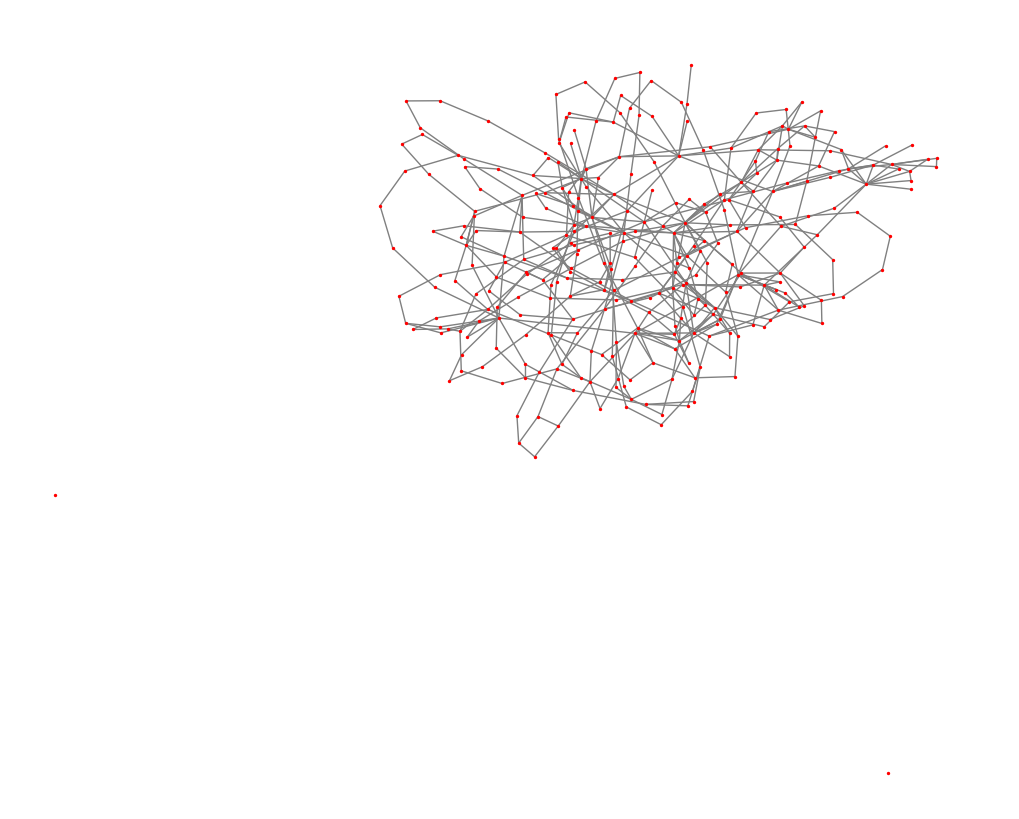

In [15]:
merged_graph = relabeled_graph_1
print("num nodes (before):", len(merged_graph.nodes))
print("num edges (before):", len(merged_graph.edges))

merged_graph = nx.compose_all([relabeled_graph_1, relabeled_graph_2])

# merge the two sets of unique nodes into one set of unique nodes
for node in relabeled_graph_2.nodes:

    if merged_graph.has_node(node):
        #print(f"Part of query graph: {node}")

        # merge metadata from two nodes together
        merge_node_cluster(merged_graph, [node, node], f"{node}_merged")

print("num nodes (after):", len(merged_graph.nodes))

print("relabeled_graph_2 edges:", len(relabeled_graph_2.edges))

print("num edges (after):", len(merged_graph.edges))

plt.figure(figsize=(10, 8))  # Set the figure size
nx.draw(merged_graph, with_labels=False, node_color='red', edge_color='gray', node_size = 2)
plt.show()

num nodes (before): 257
num nodes (after): 468
relabeled_graph_2 edges: 321
num edges (before): 314
num edges (after): 635


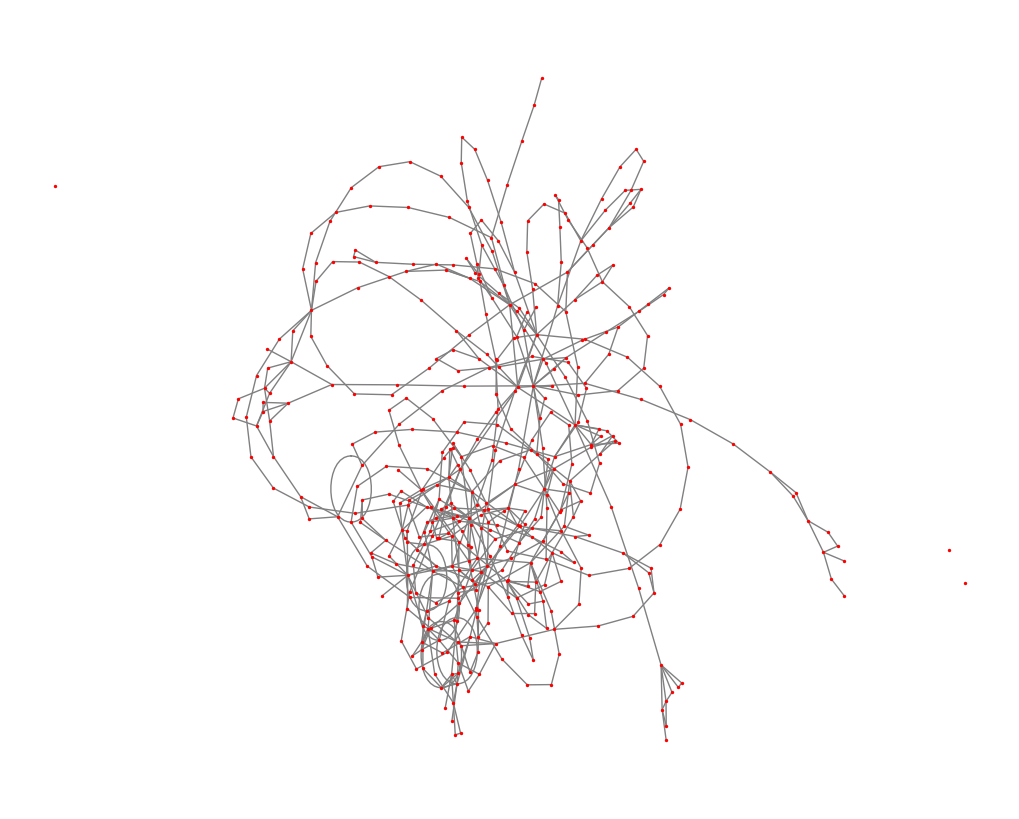

In [29]:
# create merged graph

def main():

    merged_graph = relabeled_graph_1
    print("num nodes (before):", len(merged_graph.nodes))
    
    merged_graph = nx.compose_all([relabeled_graph_1, relabeled_graph_2])
    
    # merge the two sets of unique nodes into one set of unique nodes
    for node in relabeled_graph_2.nodes:
        
        if merged_graph.has_node(node):
            #print(f"Part of query graph: {node}")
            
            # merge metadata from two nodes together
            merge_node_cluster(merged_graph, [node, node], f"{node}_merged")

    print("num nodes (after):", len(merged_graph.nodes))

    print("relabeled_graph_2 edges:", len(relabeled_graph_2.edges))
    print("num edges (before):", len(merged_graph.edges))

    # merge the two sets of edges into one set of edges,
    # removing duplicates (including those with different strandedness)
    
    for edge in relabeled_graph_2.edges:
        u = edge[0].removeprefix("group_")
        v = edge[1].removeprefix("group_")
        
        u = str(u)
        v = str(v)

        # strip "_query" if it exists at the end of the string before interpreting order, then re-add
        if "_query" in u:
            u = u.removesuffix("_query")
            u = int(u)

            if "_query" in v:
                v = v.removesuffix("_query")
                v = int(v)

                # add in absolute order
                first = min(abs(u), abs(v))
                second = max(abs(u), abs(v))

                # make strings (same reason as with nodes, bc otherwise they're interpreted as indexes)
                first = f"group_{first}_query"
                second = f"group_{second}_query"

            else: #(if "_query" not in v)
                v = int(v)

                # add in absolute order
                first = min(abs(u), abs(v))
                second = max(abs(u), abs(v))

                # make strings
                if first == abs(u):
                    first = f"group_{first}_query"
                else:
                    first = f"group_{first}"

                if second == abs(u):
                    second = f"group_{second}_query"
                else:
                    second = f"group_{second}"
                        
        else: #if "_query" not in u:
            u = int(u)

            if "_query" in v:
                v = v.removesuffix("_query")
                v = int(v)

                # add in absolute order
                first = min(abs(u), abs(v))
                second = max(abs(u), abs(v))

                # make strings
                if first == abs(v):
                    first = f"group_{first}_query"
                else:
                    first = f"group_{first}"

                if second == abs(v):
                    second = f"group_{second}_query"
                else:
                    second = f"group_{second}"
             
            else: #(if "_query" not in v)
                v = int(v)

                # add in absolute order
                first = min(abs(u), abs(v))
                second = max(abs(u), abs(v))

                # make strings 
                first = f"group_{first}"
                second = f"group_{second}"
            
        if merged_graph.has_edge(first, second):

            #print("Edge exists.")
            continue

        if not merged_graph.has_edge(first, second):
            merged_graph.add_edge(first, second)

            #print("Added edge.")

    print("num edges (after):", len(merged_graph.edges))
    
    plt.figure(figsize=(10, 8))  # Set the figure size
    nx.draw(merged_graph, with_labels=False, node_color='red', edge_color='gray', node_size = 2)
    plt.show()
    
    #print(merged_graph.nodes, merged_graph.edges)
    
    #print(merged_graph.graph['isolateNames'])
    
    nx.write_gml(merged_graph, "../../graph_merged/merged_graph.gml")

if __name__ == "__main__":
    main()

In [14]:
###### ORIGINAL

# for adding to genome ids of second graph
n_genomes_basegraph = 45

# create merged graph

def main():

    merged_graph = relabeled_graph_1
    print("num nodes (before):", len(merged_graph.nodes))

    # merge the two sets of unique nodes into one set of unique nodes
    for node in relabeled_graph_2.nodes:
        if node != "_":
            print(node)
            # remove negative but keep as string (otherwise has_node thinks
            # that node name is the node index)
            #node = int(node)
            #node = abs(node)
            #node = str(node)
            if merged_graph.has_node(node):
                
                print("Part of query graph.")
                
                #merged_graph.nodes[node]['total_sim'] += ";"
                #to_append = ";".join(str(int(num) + n_genomes_basegraph) for num in sim_graph_59.nodes[node]['total_sim'].split(";"))
                #merged_graph.nodes[node]['total_sim'] += to_append

                #print("merged total (after):", merged_graph.nodes[node]['total_sim'])

                #set_old = set(merged_graph.nodes[node]['members_sim']) - set(";")    
                #set_to_add = set(sim_graph_59.nodes[node]['members_sim']) - set(";")
                #set_add_reindexed = {str(int(num) + n_genomes_basegraph) for num in set_to_add}
                #set_total = set_old | set_add_reindexed
                #set_total_str = ";".join(set_total)
                #merged_graph.nodes[node]['members_sim'] = set_total_str
                
                #print("merged members (after):", merged_graph.nodes[node]['members_sim'])
                
            if not merged_graph.has_node(node):
                
                print("Add new node to graph.")
                
                merged_graph.add_node(node)
                #members_sim=[],
                #total_sim=[])

                #### REINDEX
                
                #members_sim_unindexed = sim_graph_59.nodes[node]['members_sim']
                #print("members_sim_unindexed:", members_sim_unindexed)
                #members_sim_indexed = ";".join(str(int(num) + n_genomes_basegraph) for num in members_sim_unindexed.split(";"))
                #merged_graph.nodes[node]['members_sim'] = members_sim_indexed
                #print("members sim indexed", merged_graph.nodes[node]['members_sim'])

                #total_sim_unindexed = sim_graph_59.nodes[node]['total_sim']
                #print("total_sim_unindexed:", total_sim_unindexed)
                #total_sim_indexed = ";".join(str(int(num) + n_genomes_basegraph) for num in total_sim_unindexed.split(";"))
                #merged_graph.nodes[node]['total_sim'] = total_sim_indexed
                #print("total_sim indexed:", merged_graph.nodes[node]['total_sim'])

    print("num nodes (after):", len(merged_graph.nodes))

    print("relabeled_graph_2 edges:", len(relabeled_graph_2.edges))
    print("num edges (before):", len(merged_graph.edges))

    # merge the two sets of edges into one set of edges,
    # removing duplicates (including those with different strandedness)

    for edge in relabeled_graph_2.edges:
        u = edge[0]
        v = edge[1]
        
        # strip "_query" if it exists at the end of the string before interpreting order, then re-add
        if "_query" in u:
            u = u.removesuffix("_query")
            u = int(u)
                if "_query" in v:
                    v = v.removesuffix("_query")
                    v = int(v)
            
                    # add in absolute order
                    first = min(abs(u), abs(v))
                    second = max(abs(u), abs(v))

                    # make strings (same reason as with nodes, bc otherwise they're interpreted as indexes)
                    first = f"{first}_query"
                    second = f"{second}_query"
                    
                if "_query" not in v:
                    v = int(v)
            
                    # add in absolute order
                    first = min(abs(u), abs(v))
                    second = max(abs(u), abs(v))

                    # make strings (same reason as with nodes, bc otherwise they're interpreted as indexes)
                    if first == abs(u):
                        first = f"{first}_query"
                        
                    if second == abs(u):
                        second = f"{second}_query"
            
            if "_query" not in u:
            u = int(u)
            
                if "_query" in v:
                    v = int(v)
            
                    # add in absolute order
                    first = min(abs(u), abs(v))
                    second = max(abs(u), abs(v))

                    # make strings (same reason as with nodes, bc otherwise they're interpreted as indexes)
                    if first == abs(v):
                        first = f"{first}_query"
                        
                    if second == abs(v):
                        second = f"{second}_query"
            
                if "_query" not in v: 
                    v = int(v)
            
                    # add in absolute order
                    first = min(abs(u), abs(v))
                    second = max(abs(u), abs(v))

                    # make strings (same reason as with nodes, bc otherwise they're interpreted as indexes)
                    first = str(first)
                    second = str(second)

            if merged_graph.has_edge(first, second):
                
                print("Edge exists.")
                
                #print("merged edge existing:", merged_graph.edges[edge[0], edge[1]]['members_sim'])

                #set_old = set(merged_graph.edges[edge[0], edge[1]]['members_sim']) - set(";")    
                #set_to_add = set(sim_graph_59.edges[edge[0], edge[1]]['members_sim']) - set(";")
                #set_add_reindexed = {str(int(num) + n_genomes_basegraph) for num in set_to_add}
                #set_total = set_old | set_add_reindexed
                #set_total_str = ";".join(set_total)
                #merged_graph.edges[edge[0], edge[1]]['members_sim'] = set_total_str
                
                #print("merged edge updated:", merged_graph.edges[edge[0], edge[1]]['members_sim'])

                #print("merged edge total existing:", merged_graph.edges[edge[0], edge[1]]['total_sim'])

                #merged_graph.edges[edge[0], edge[1]]['total_sim'] += ";"
                #to_append = ";".join(str(int(num) + n_genomes_basegraph) for num in sim_graph_59.edges[edge[0], edge[1]]['total_sim'].split(";"))
                #merged_graph.edges[edge[0], edge[1]]['total_sim'] += to_append
                
                #print("merged edge total updated:", merged_graph.edges[edge[0], edge[1]]['total_sim'])

                #print("strand sim before:", merged_graph.edges[edge[0], edge[1]]['strand_sim'])

                #merged_graph.edges[edge[0], edge[1]]['strand_sim'] += ";"
                #merged_graph.edges[edge[0], edge[1]]['strand_sim'] += sim_graph_59.edges[edge[0], edge[1]]['strand_sim']
                
                #print("strand sim after:", merged_graph.edges[edge[0], edge[1]]['strand_sim'])

            if not merged_graph.has_edge(first, second):
                merged_graph.add_edge(first, second)
                                #members_sim = [],
                                #strand_sim=[],
                                #total_sim=[])
                            
                print("Added edge.")

                ### REINDEX (strand doesn't need to be indexed)

                #members_sim_unindexed = sim_graph_59.edges[edge[0], edge[1]]['members_sim']
                #print("members_sim_unindexed:", members_sim_unindexed)
                #members_sim_indexed = ";".join(str(int(num) + n_genomes_basegraph) for num in members_sim_unindexed.split(";"))
                #merged_graph.edges[edge[0], edge[1]]['members_sim'] = members_sim_indexed
                #print("members sim indexed", merged_graph.edges[edge[0], edge[1]]['members_sim'])

                #total_sim_unindexed = sim_graph_59.edges[edge[0], edge[1]]['total_sim']
                #print("total_sim_unindexed:", members_sim_unindexed)
                #total_sim_indexed = ";".join(str(int(num) + n_genomes_basegraph) for num in total_sim_unindexed.split(";"))
                #merged_graph.edges[edge[0], edge[1]]['total_sim'] = total_sim_indexed
                #print("total_sim indexed:", merged_graph.edges[edge[0], edge[1]]['total_sim'])

                #print("strand sim before:", sim_graph_59.edges[edge[0], edge[1]]['strand_sim'])
                #merged_graph.edges[edge[0], edge[1]]['strand_sim'] = sim_graph_59.edges[edge[0], edge[1]]['strand_sim']
                #print("strand sim after:", merged_graph.edges[edge[0], edge[1]]['strand_sim'])

    print("num edges (after):", len(merged_graph.edges))
    
    nx.write_gml(merged_graph, "../../graph_merged/merged_graph.gml")

if __name__ == "__main__":
    main()

IndentationError: unexpected indent (17617792.py, line 79)

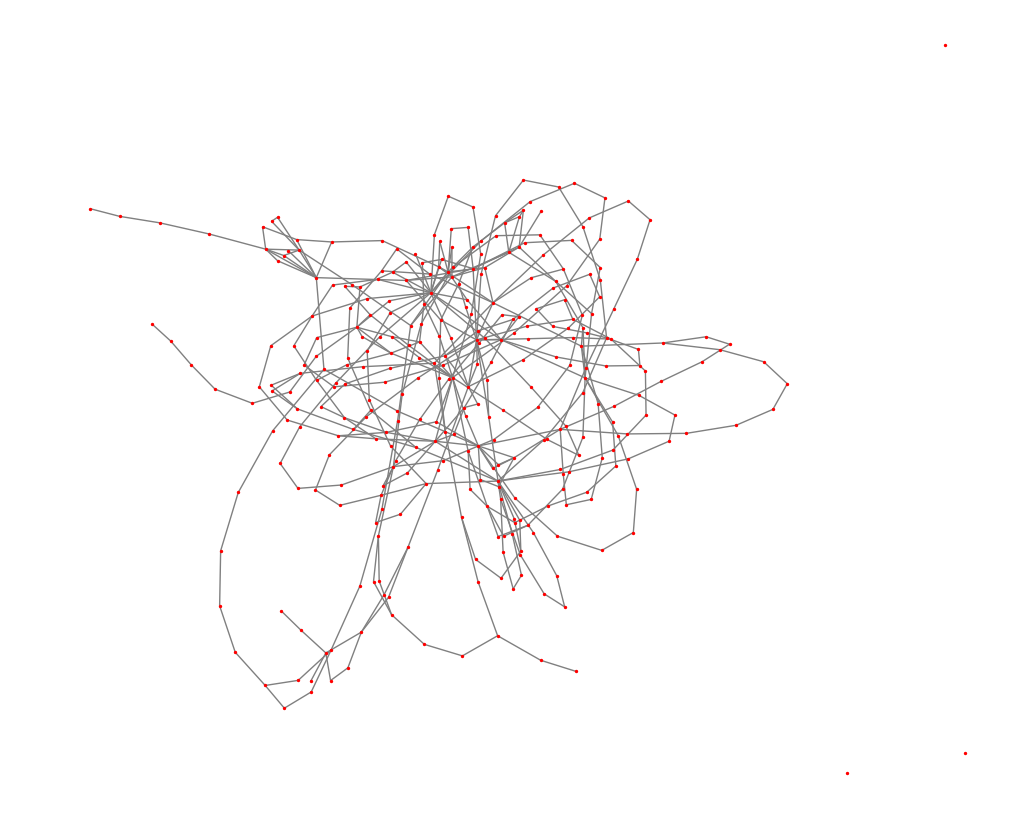

In [51]:
graph_all = nx.read_gml("../../graph_all/final_graph.gml")

plt.figure(figsize=(10, 8))  # Set the figure size
nx.draw(graph_all, with_labels=False, node_color='red', edge_color='gray', node_size = 2)
plt.show()

In [3]:
# add metadata (geneIDs)

gene_ids = {}
    centroids_to_nodes = defaultdict(list)
    for cluster in clusters:
        for sid in cluster:
            gene_ids[sid] = cluster[0]
    all_centroids = set(list(gene_ids.values()))
    
for G in graphs:
    for node in G.nodes():
        G.nodes[node]["geneID"] = list(
            set([
                gene_ids[sid] for sid in G.nodes[node]['seqIDs']
                if "refound" not in sid
            ]))
        for sid in G.nodes[node]["centroid"]:
            centroids_to_nodes[sid].append(node)
            
#        G.nodes[node]["dna"] = [
#            centroid_to_seqs[sid][1] for sid in G.nodes[node]["centroid"]
#        ]#
#
#        G.nodes[node]["protein"] = [
#            centroid_to_seqs[sid][0] for sid in G.nodes[node]["centroid"]
#        ]
#        G.nodes[node]["longCentroidID"] = max([
#            (len(seq), sid) for seq, sid in zip(G.nodes[node]["dna"],
#                                                G.nodes[node]["centroid"])
 #       ])

IndentationError: unexpected indent (1206283635.py, line 4)

In [77]:
# define function to generate dna hashes from node metadata

import hashlib

def get_dna_hashes(G):
    
    dna_hashes = {} # create dictionary
    
    for node in G.nodes:
        dna_seqs = G.nodes[node].get('dna', [])

        # hash each DNA string
        hashes = [
            hashlib.md5(seq.encode()).hexdigest() 
            for seq in dna_seqs
        ]

        dna_hashes[node] = hashes
    return dna_hashes

def filter_common(list1, list2):
    set1 = set(val for sublist in list1 for val in sublist)
    set2 = set(val for sublist in list2 for val in sublist)

    print("Set 1:", set1)
    print("Set 2:", set2)

    common = set1 & set2
    print("Common:", common)

    f1 = [[v for v in sub if v in common] for sub in list1]
    f2 = [[v for v in sub if v in common] for sub in list2]
    return f1, f2

def build_labels_from_hash_dict(hash_dict):
    labels = []
    elements = []
    for cluster_id, hash_list in hash_dict.items():
        for h in hash_list:
            elements.append(h)
            labels.append(cluster_id)
    return elements, labels

def compute_rand_index_with_sklearn(dict1, dict2):
    # Build hash → cluster label list for both
    elements1, labels1 = build_labels_from_hash_dict(dict1)
    elements2, labels2 = build_labels_from_hash_dict(dict2)

    # Use only hashes that appear in both dictionaries
    common = set(elements1) & set(elements2)
    if len(common) < 2:
        return 1.0

    # Create aligned label lists
    h_to_l1 = {h: l for h, l in zip(elements1, labels1) if h in common}
    h_to_l2 = {h: l for h, l in zip(elements2, labels2) if h in common}
    sorted_hashes = sorted(common)

    aligned_labels1 = [h_to_l1[h] for h in sorted_hashes]
    aligned_labels2 = [h_to_l2[h] for h in sorted_hashes]

    return rand_score(aligned_labels1, aligned_labels2)

In [99]:
# read in graph_all

graph_all = ["/nfs/research/jlees/jacqueline/atb_analyses/merge_tests/COG_merge/graph_all/final_graph.gml"]

graph_all, isolate_names, id_mapping = load_graphs(graph_all)
graph_all = graph_all[0]

#list(graph_all.nodes(data=True))

In [110]:
# get dna hashes for merged and all graphs

dna_hashes_merged = get_dna_hashes(merged_graph)
dna_hashes_all = get_dna_hashes(graph_all)

# get Rand index 

#hashlist_merged = list(dna_hashes_merged.values())
#hashlist_all = list(dna_hashes_all.values())

#Invert dicts to get item → cluster mappings

dict1 = get_dna_hashes(merged_graph)
dict2 = get_dna_hashes(graph_all)


def flatten_clusters(cluster_dict):
    return {item: cluster for cluster, items in cluster_dict.items() for item in items}

def label_encode(labels):
    label_map = {label: idx for idx, label in enumerate(set(labels))}
    return [label_map[label] for label in labels]

# Flatten both dictionaries
item_to_cluster1 = flatten_clusters(dict1)
item_to_cluster2 = flatten_clusters(dict2)

# Only keep items that exist in both
common_items = sorted(set(item_to_cluster1.keys()) & set(item_to_cluster2.keys()))

labels1 = [item_to_cluster1[item] for item in common_items]
labels2 = [item_to_cluster2[item] for item in common_items]

# Encode cluster labels as integers
encoded1 = label_encode(labels1)
encoded2 = label_encode(labels2)

# Compute Rand Index
ri = rand_score(encoded1, encoded2)
print(f"Rand Index: {ri}")



item_to_cluster1 = {}
for cluster_id, items in dict1.items():
    for item in items:
        item_to_cluster1[item] = cluster_id

item_to_cluster2 = {}
for cluster_id, items in dict2.items():
    for item in items:
        item_to_cluster2[item] = cluster_id

# Step 2: Make sure all items are aligned and sorted
all_items = sorted(item_to_cluster1.keys())
labels1 = [item_to_cluster1[item] for item in all_items]
labels2 = [item_to_cluster2[item] for item in all_items]

# Step 3: Convert cluster names to integers
def label_encode(labels):
    label_map = {label: i for i, label in enumerate(set(labels))}
    return [label_map[label] for label in labels]

encoded1 = label_encode(labels1)
encoded2 = label_encode(labels2)


# Step 4: Compute Rand Index
ri = rand_score(encoded1, encoded2)
print(f"Rand Index: {ri}")


a = np.concatenate(list(dna_hashes_merged.values()))
b = np.concatenate(list(dna_hashes_all.values()))

# Step 1: Create a mapping of element to index for both arrays
a_indices = {value: idx for idx, value in enumerate(a)}
b_indices = {value: idx for idx, value in enumerate(b)}

# Step 2: Find common elements
common = set(a) & set(b)

a_only = [val for val in a if val not in common]
b_only = [val for val in b if val not in common]


# Step 3: Sort based on 'a' order
matched_a = [(val, a_indices[val]) for val in a if val in common]
matched_b = [(val, b_indices[val]) for val in a if val in common]

# Step 4: Extract values and indices
a_sorted_values = [val for val, idx in matched_a]
a_sorted_indices = [idx for val, idx in matched_a]

b_sorted_values = [val for val, idx in matched_b]
b_sorted_indices = [idx for val, idx in matched_b]

# Results
#print("Matched values:", a_sorted_values)
#print("Indices in a:", a_sorted_indices)
#print("Indices in b:", b_sorted_indices)


# Step 5: Removed values and their indices
a_removed = [(val, a_indices[val]) for val in a_only]
b_removed = [(val, b_indices[val]) for val in b_only]
print("Removed from a:", a_removed)
print("Removed from b:", b_removed)


#filtered_hashlists = filter_common(dna_hashes_all, hashlist_merged)

# from sorted indices, put keys into arrays, replicated so that the key is repeated as many values as it has

# sort keylists by index of sorted values



# compute Rand

#rand = sklearn_metrics.rand_score(hashlist_all, hashlist_merged)

print(rand)

KeyError: '00bc9fc6108c8bd200252f2d74f3425d'

In [ ]:
# context search

G.neighbors() # from nx